# Lab Two: Classification

Dylan Scott, Satvik Ajmera, Nnenna Okpara, Jobin Joseph

# NTSB Aviation Accident and Incident Data (NTSB)

Source: https://data.ntsb.gov/avdata

From the source, we will be using the NTSB data which consists of various attributes related to aviation accidents and incidents. This data includes incidents and accidents that have occured till date. 

The goal for this lab is to build two classification models that predict:

1. Predicting if an incident/accident has resulted in an injury (binary classification)
2. Predicting the phase of flight for an incident that has occured (multiclass classification)

For this we will create two dataframes for these two classification problems.

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation Part 1

**[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.**

In [2]:
#Read in the Aviation Data
final_data = pd.read_csv("../Data/final_data.csv",low_memory=False,dtype={'damage': str})
#Delete columns that were imported incorrectly
del final_data["Unnamed: 0"]
del final_data["dprt_state.1"]
del final_data["dprt_city"]
del final_data["index"]
del final_data["ntsb_no_x"]
del final_data['wind_vel_ind']
del final_data["ev_id"]
del final_data['ev_highest_injury']

final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115706 entries, 0 to 115705
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   acft_make          115643 non-null  object 
 1   acft_model         115630 non-null  object 
 2   cert_max_gr_wt     98673 non-null   float64
 3   acft_category      115287 non-null  object 
 4   damage             113877 non-null  object 
 5   far_part           114925 non-null  object 
 6   afm_hrs_last_insp  60298 non-null   float64
 7   type_fly           108599 non-null  object 
 8   dprt_state         108791 non-null  object 
 9   rwy_len            64222 non-null   float64
 10  rwy_width          63110 non-null   float64
 11  ev_type            115706 non-null  object 
 12  ev_city            115646 non-null  object 
 13  ev_state           109635 non-null  object 
 14  ev_country         115199 non-null  object 
 15  inj_f_grnd         51624 non-null   float64
 16  in

### 1a. Data Preparation for predicting Injury

In [3]:
#replace the all empty values to Nan
final_data= final_data.replace(r'^\s+$', np.nan, regex=True)

In [4]:
#Upper case all factor levels for each categorical variable
final_data['acft_make'] = final_data['acft_make'].str.upper()
final_data['acft_category'] = final_data['acft_category'].str.upper()
final_data['damage'] = final_data['damage'].str.upper()
final_data['type_fly'] = final_data['type_fly'].str.upper()
final_data['dprt_state'] = final_data['dprt_state'].str.upper()
final_data['ev_city'] = final_data['ev_city'].str.upper()
final_data['ev_type'] = final_data['ev_type'].str.upper()
final_data['ev_city'] = final_data['ev_city'].str.upper()
final_data['ev_country'] = final_data['ev_country'].str.upper()
final_data['sky_cond_ceil'] = final_data['sky_cond_ceil'].str.upper()
final_data['sky_cond_nonceil'] = final_data['sky_cond_nonceil'].str.upper()
final_data['wx_int_precip'] = final_data['wx_int_precip'].str.upper()
final_data['phase_flt_spec'] = final_data['phase_flt_spec'].str.upper()

In [5]:
final_data.loc[final_data['damage'].str.contains('UNK', na=False), 'damage'] = 'UNK'

#rename the injuries columns to make them easier to read
final_data = final_data.rename(columns={"inj_tot_f": "Total_Fatal_Injuries", 
                                        "inj_tot_s":"Total_Serious_Injuries",
                                        "inj_tot_m":"Total_Minor_Injuries",
                                        "inj_tot_n":'Total_Uninjured',
                                        "inj_tot_t":"Total_Injuries_Flight"})

#fill in 0s when there wasn't an injury in that category
final_data.update(final_data[['Total_Fatal_Injuries','Total_Serious_Injuries',
                              'Total_Minor_Injuries','Total_Uninjured',
                              'Total_Injuries_Flight','inj_f_grnd',
                              'inj_m_grnd','inj_s_grnd']].fillna(0))

In [6]:
final_data.dropna(subset=['cert_max_gr_wt','afm_hrs_last_insp',
                          'rwy_len','rwy_width'],inplace=True)
final_data = final_data.reset_index(drop=True)
final_data.update(final_data.fillna("UNK"))
phase_df = final_data.copy()
final_data.head(3)

,acft_make,acft_model,cert_max_gr_wt,acft_category,damage,far_part,afm_hrs_last_insp,type_fly,dprt_state,rwy_len,...,inj_s_grnd,Total_Fatal_Injuries,Total_Minor_Injuries,Total_Uninjured,Total_Serious_Injuries,Total_Injuries_Flight,sky_cond_ceil,sky_cond_nonceil,wx_int_precip,phase_flt_spec
0,BOEING,747-100,750000.0,AIR,MINR,121,113.0,UNK,JA,11800.0,...,0.0,0.0,0.0,4.0,0.0,0.0,NONE,SCAT,UNK,LANDING
1,CESSNA,172,2300.0,AIR,SUBS,091,40.0,PERS,UNK,6398.0,...,0.0,0.0,0.0,1.0,0.0,0.0,BKN,UNK,LGT,UNKNOWN
2,CESSNA,207,3800.0,AIR,SUBS,135,49.0,UNK,AK,2610.0,...,0.0,0.0,0.0,1.0,0.0,0.0,BKN,UNK,UNK,DESCENT


In [7]:
#we want to account for ALL injuries. This includes injuries on the ground as well as passangers
#Here we will make a new column that shows total injuries including ground ones
final_data['Total_Injuries_Ground'] = final_data['inj_f_grnd']+final_data['inj_m_grnd']+final_data['inj_s_grnd']
final_data['Total_Injuries'] = final_data['Total_Injuries_Ground']+final_data['Total_Injuries_Flight']
final_data['Injury'] = np.where(final_data['Total_Injuries'] >0,1,0)
injuries = final_data["Injury"].value_counts().reset_index()
injuries.head(3)

,index,Injury
0,1,18750
1,0,16677


In [8]:
final_df = final_data.copy()
#Since we added up all of our injuries we don't need the other columns that include injury count since it will be colinear to our prediction variable
final_df = final_df.drop(['Total_Fatal_Injuries','Total_Serious_Injuries','Total_Minor_Injuries',
                          'Total_Uninjured','Total_Injuries_Flight','inj_f_grnd','inj_m_grnd',
                          'inj_s_grnd','Total_Injuries_Ground',"Total_Injuries"],axis = 1)
final_df = final_df.reset_index(drop=True)

#### Preprocessing and Final Dataset description for Binary Classification: `Injury` 

We fixed the levels of columns that should have been grouped together for the `damage` predictor. We fixed the levels of the `ev_city`, by making all the city names uppercase so they would be grouped together. Then, we took the subset of the continuous predictors: `cert_max_gr_wt`,`afm_hrs_last_insp`,`rwy_len`, and `rwy_width` and removed all the NAs. We were left with approximately 35,000 rows that would be usable for prediction.

The NTSB database allowed use to include ground injuries in addition to flight injuries. So we renamed the columns, replaced the NAs in these columns with 0 and summed all them to get a total injuries column. We wanted to only include the total injuries and drop the other types of injury columns. From there, we converted the total injuries column to a binary variable for classification. If the total injuries were greater than 1, it is considered injured and less than 1 is uninjured. Our last step was to impute all the NA's for the categorical values with an unknown value called `UNK` In all, we are left with the dataframe `final_df` which consisted of 21 columns and 35,427 observations. 

Of the total 35,427 observations, 18750 observations were reported as injured and 16677 were reported as uninjured. This column called `Injury` is the response variable, we would like to predict for the classification problem.

Our final preprocess method was one-hot encoding our categorical variables and standardize and scaled continuous predictors. We did this, because standardizing and scaling some predictors are not on the same scale such as `cert_max_gr_wt`.

In [9]:
injury_df = final_df.copy()

Now we will one hot encode `injury_df` so they can be used in our models.

1. For classification of `Injury`, the our X and y are called `inj_X` and `inj_y`. 

In [10]:
inj_X = injury_df.drop("Injury", axis = 1).copy()
inj_y = injury_df["Injury"].copy()

#### One-Hot Encoding `inj_X` and `inj_y`

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
numeric_features = ['cert_max_gr_wt',"afm_hrs_last_insp","rwy_width",'rwy_len']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler(with_mean=False))])

categorical_features = ['acft_make', 'acft_model', 'acft_category', 'damage', 'type_fly', 'dprt_state','ev_type', 'ev_state', 'sky_cond_ceil', 'sky_cond_nonceil', 'wx_int_precip', 'phase_flt_spec','ev_city','ev_country','far_part']


categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop="first"))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

inj_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [12]:
inj_X = inj_pipeline.fit_transform(inj_X)

In [13]:
inj_X

<35427x18468 sparse matrix of type '<class 'numpy.float64'>'
	with 587128 stored elements in Compressed Sparse Row format>

#### Label encoding `inj_y`

In [14]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE.fit(inj_y)
inj_y = LE.transform(inj_y)
inj_y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

### 1b. Data Preparation for predicting the Phase of Flight

In [15]:
#Removed columns that contain UNKNOWN, UNK and OTHER factor levels
new_phase_df = phase_df[(phase_df['phase_flt_spec'] != "UNKNOWN") & (phase_df['phase_flt_spec'] != "UNK") & (phase_df['phase_flt_spec'] != "OTHER")].copy()
new_phase_df["phase_flt_spec"].value_counts()

LANDING        16743
TAKEOFF         5776
APPROACH        3300
DESCENT         2995
MANEUVERING     1569
CRUISE          1218
CLIMB            923
TAXI             741
STANDING         393
GOAROUND         301
HOVER             94
Name: phase_flt_spec, dtype: int64

In [16]:
new_phase_df.reset_index(drop=True,inplace=True)

In [17]:
new_phase_df["phase_flt_spec"] = new_phase_df["phase_flt_spec"].replace({"APPROACH":1,"CLIMB":2,
                                                                         "CRUISE":3,"DESCENT":4,
                                                                         "GOAROUND":5,"HOVER":6,
                                                                         "LANDING":7,"MANEUVERING":8,
                                                                         "STANDING":9,"TAKEOFF":10,
                                                                         "TAXI":11})

#### Preprocessing and Final Dataset description for Multiclass Classification: `phase_flt_spec` 


The response variable for the second classification problem is called `phase_flt_spec`. This variable is the broad phase of flight where an incident has occurred. So there are three factor levels that were removed called `UNKNOWN`, `UNK` and `OTHER`, because we would like to predict specific broad phases of flights where aviation accidents occured. Additionally, we wanted to include the several injury columns in this dataframe because it may be important in predicting the broad phase. inj_f_grnd, inj_m_grnd, and inj_s_grnd represent the number of minor, fatal and serious ground injuries. Total_Fatal_Injuries, Total_Minor_Injuries, Total_Serious_Injuries correspond to the number of injuries occured that were serious, minor, or fatal on the flight. The Total_Uninjured correspond to the total number of uninjured people on the flight and Total_Injuries_Flight correspond to the total number of injuries that have occured on the flight. So we are left with 26 predictors and 35,427 instances. The response variable has 11 factor levels for each broad phase of flight which have been coded to integers. Shown here:

|phase_flt_spec||Code|
|----||----|
|APPROACH||1|
|CLIMB||2|
|CRUISE||3|
|DESCENT||4|
|GOAROUND||5|
|HOVER||6|
|LANDING||7|
|MANEUVERING||8|
|STANDING||9|
|TAKEOFF||10|
|TAXI||11|

Our final preprocess method was one-hot encoding our categorical variables, standardize and scale continuous predictors for the same reasons before.

Now we will one hot encode `new_phase_df` so they can be used in our models.

2. For classfication of `phase_flt_spec` (Broad Phase of Flight), the X and y are called `phase_X` and `phase_y`

In [18]:
new_phase_df = new_phase_df.drop('ev_city', axis = 1).copy()

phase_X = new_phase_df.drop("phase_flt_spec", axis = 1).copy()
phase_y = new_phase_df["phase_flt_spec"].copy()

In [19]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
numeric_features = ['cert_max_gr_wt',"afm_hrs_last_insp","rwy_width",'rwy_len','inj_f_grnd','inj_m_grnd',
                    'inj_s_grnd','Total_Fatal_Injuries','Total_Minor_Injuries','Total_Uninjured',
                    'Total_Serious_Injuries','Total_Injuries_Flight']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler(with_mean=False))])

categorical_features = ['acft_make', 'acft_model', 'acft_category', 'damage', 'type_fly', 'dprt_state','ev_state', 'sky_cond_ceil', 'sky_cond_nonceil', 'wx_int_precip', 'ev_country','far_part']


categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop="first"))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

phase_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [20]:
phase_X = phase_pipeline.fit_transform(phase_X)

In [21]:
phase_X

<34053x8831 sparse matrix of type '<class 'numpy.float64'>'
	with 555024 stored elements in Compressed Sparse Row format>

#### One-Hot Encoding `phase_X` and `phase_y`

In [22]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE.fit(phase_y)
phase_y = LE.transform(phase_y)
phase_y

array([6, 3, 0, ..., 4, 6, 9], dtype=int64)

# Data Preparation Part 2

**[5 points] Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).**

**Our final dataframe for classifying `Injury` is called `injury_df`**

In [23]:
injury_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35427 entries, 0 to 35426
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   acft_make          35427 non-null  object 
 1   acft_model         35427 non-null  object 
 2   cert_max_gr_wt     35427 non-null  float64
 3   acft_category      35427 non-null  object 
 4   damage             35427 non-null  object 
 5   far_part           35427 non-null  object 
 6   afm_hrs_last_insp  35427 non-null  float64
 7   type_fly           35427 non-null  object 
 8   dprt_state         35427 non-null  object 
 9   rwy_len            35427 non-null  float64
 10  rwy_width          35427 non-null  float64
 11  ev_type            35427 non-null  object 
 12  ev_city            35427 non-null  object 
 13  ev_state           35427 non-null  object 
 14  ev_country         35427 non-null  object 
 15  sky_cond_ceil      35427 non-null  object 
 16  sky_cond_nonceil   354

#### Variable Description Table: `injury_df`

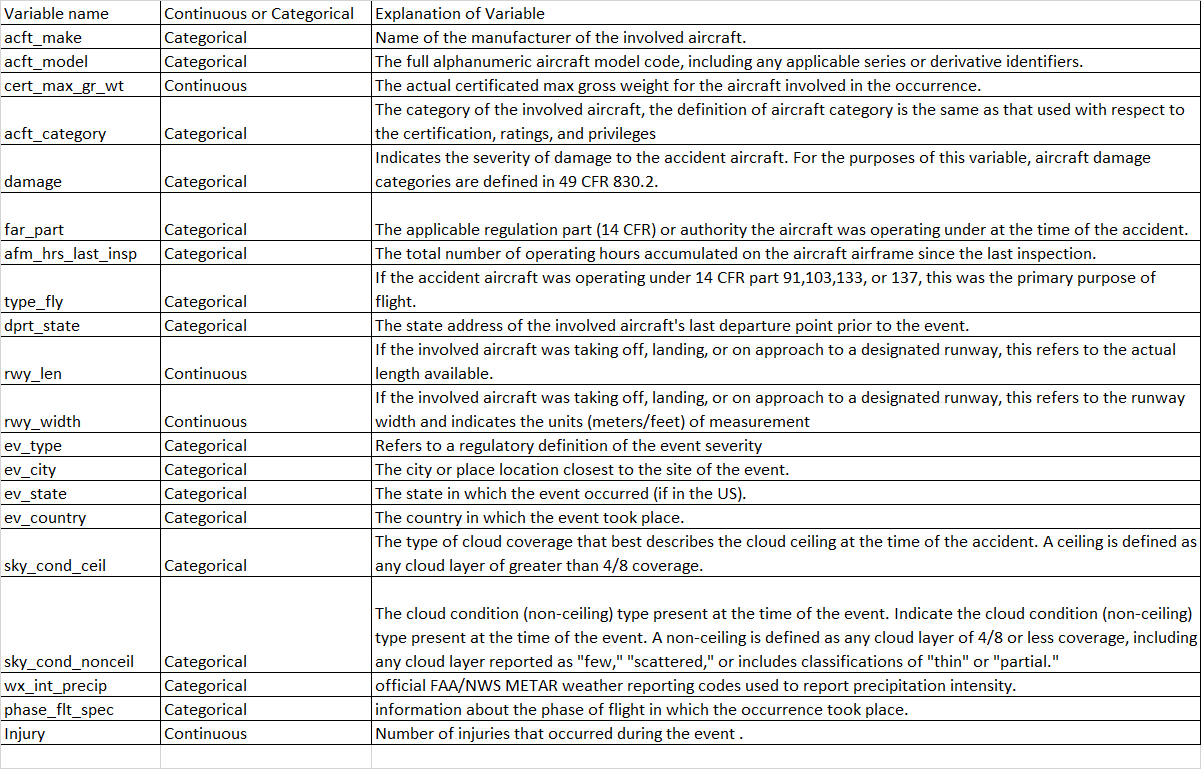

**The final dataframe for classifying `phase_flt_spec` is called `new_phase_df`**

In [24]:
new_phase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34053 entries, 0 to 34052
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   acft_make               34053 non-null  object 
 1   acft_model              34053 non-null  object 
 2   cert_max_gr_wt          34053 non-null  float64
 3   acft_category           34053 non-null  object 
 4   damage                  34053 non-null  object 
 5   far_part                34053 non-null  object 
 6   afm_hrs_last_insp       34053 non-null  float64
 7   type_fly                34053 non-null  object 
 8   dprt_state              34053 non-null  object 
 9   rwy_len                 34053 non-null  float64
 10  rwy_width               34053 non-null  float64
 11  ev_type                 34053 non-null  object 
 12  ev_state                34053 non-null  object 
 13  ev_country              34053 non-null  object 
 14  inj_f_grnd              34053 non-null

#### Variable Description Table: `new_phase_df`

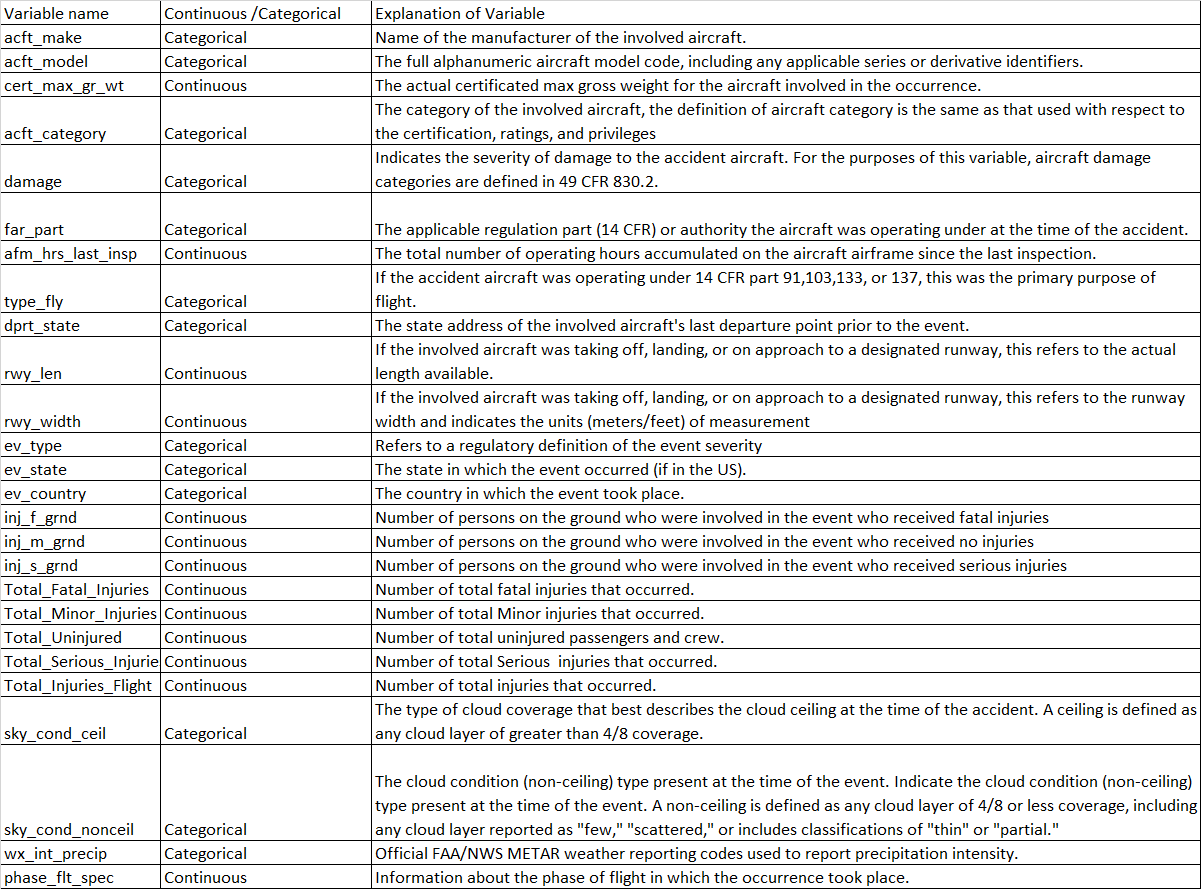

# Modeling and Evaluation 1

**[10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.**

The evaluation metrics chosen were accuracy, precision, and recall. The first problem is a binary classification to predict injury. The second is a multi-classification problem, classifying broad phase of flight.

#### Accuracy
Accuracy is the number of True Positives and True Negatives divided by the total number of predictions. This will be used to predict which model performs better at prediction.

$Accuracy = \frac{TruePositive + TrueNegative}{TruePositive + TrueNegative + FalsePositive + FalseNegative}$

#### Precision
Precision is the number of True Positives divided by the number of positive results predicted by the classifier.  It is used to measure the exactness of classifiers.

$Precision = \frac{TP}{PP}$

#### Recall
Recall is the number of positive predictions divided by the number of positive class values. It is a measure of a classifier completeness. A low recall indicates many false negatives.

$Recall = \frac{TP}{P}$


### Injury Classification
Since this is a binary classification, accuracy will be an important metric in predicting injury. We will use a grid search to improve and make our models more accurate. In addition to accuracy, Precision and recall will be used to choose our final model.


### Phase of flight Classification
Since this is a multi-class classification with an imbalanced dataset, precision and recall would be important metrics in predicting the phase of flight. Accuracy alone does not illustrate the full story when working with class-imbalanced problems. Accuracy is not a strong predictor for multi-class classification. Precision will be used to measure the exactness and recall will be used to measure the completeness of our model. 

# Modeling and Evaluation 2

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit 
cv_log = StratifiedShuffleSplit(n_splits=5,test_size=0.10, random_state=42)

**[10 points] Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.**

For every model moving forward we used sklearn's StratifiedShuffleSplit. We chose 5 folds and test split percentage of 10% to improve the runtime of the models. This chosen method was especially important for multiclass classification because the folds are made by preserving the percentage of samples for each class.

# Modeling and Evaluation 3

**[20 points] Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.**

The three models we choose are: Logistic Regression, KNN and Random Forest. To adjust parameters we have used a gridsearch for each model. We used these methods for both Phase of Flight and Injury.

## `Logistic Regression`

#### Logistic Regression for predicting `Injury`

In [26]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
import time
lr_clf = LogisticRegression(solver='liblinear', penalty="l2",max_iter=1000,random_state=42)
iter_num=0
for train_indices, test_indices in cv_log.split(inj_X,inj_y): 
#     start = time.time()
#     elapsed_time = (time.time() - start)
    X_train = inj_X[train_indices]
    y_train = inj_y[train_indices]
    
    X_test = inj_X[test_indices]
    y_test = inj_y[test_indices]
    lr_clf.fit(X_train,y_train)  # train object

    y_hat = lr_clf.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print('accuracy:', acc )
#     print(conf )
#     print('CV Time: ', elapsed_time)
    iter_num+=1

====Iteration 0  ====
accuracy: 0.8323454699407282
====Iteration 1  ====
accuracy: 0.820773355913068
====Iteration 2  ====
accuracy: 0.8151284222410387
====Iteration 3  ====
accuracy: 0.8185153824442563
====Iteration 4  ====
accuracy: 0.8210556025966695
Wall time: 8.22 s


#### Adjusting Parameters Using Gridsearch for `Logistic Regression`: Injury

In [27]:
%%time
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100]
              ,'class_weight': ['balanced']
              ,'random_state': [42]
              ,'solver': ['liblinear']
              ,'max_iter':[1000]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
inj_GridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_log # KFolds = 5
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
inj_GridSearch.fit(inj_X, inj_y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Wall time: 29.7 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced'], 'max_iter': [1000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['liblinear']},
             scoring='accuracy', verbose=1)

In [28]:
print(inj_GridSearch.best_estimator_)
lr_inj_best_est = inj_GridSearch.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')


In [29]:
print(inj_GridSearch.best_params_)

{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}


In [30]:
print('Best Score - LogisticReg:', inj_GridSearch.best_score_ )

Best Score - LogisticReg: 0.827321478972622


#### Logistic Regression for predicting `phase_flt_spec`

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
import time

lr_phase = LogisticRegression(solver='liblinear', penalty="l2",max_iter=1000,random_state=42)

iter_num=0

for train_indices, test_indices in cv_log.split(phase_X,phase_y): 
    X_train = phase_X[train_indices]
    y_train = phase_y[train_indices]
    X_test = phase_X[test_indices]
    y_test = phase_y[test_indices]
    
    lr_phase.fit(X_train,y_train)  # train object
    y_hat = lr_phase.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print('accuracy:', acc )
    print(conf )
    iter_num+=1

====Iteration 0  ====
accuracy: 0.5540223135642983
[[  58    0    2   26    0    0  209    5    1   29    0]
 [   1   18    0   16    0    0   51    0    0    6    0]
 [   4    0    9   24    0    0   62    9    0   14    0]
 [  27   12    1   68    0    1  130   27    1   33    0]
 [   0    0    0    3    0    0   24    1    0    2    0]
 [   0    0    2    1    0    0    4    2    0    0    0]
 [  16    4    1   21    1    0 1532   11    1   88    0]
 [   8    0    4   27    0    0   63   34    0   21    0]
 [   2    3    1    3    0    0   20    3    1    6    0]
 [  17    6    0   19    0    0  363    5    2  166    0]
 [   2    0    1    1    0    0   63    0    0    6    1]]
====Iteration 1  ====
accuracy: 0.5375807398708162
[[  50    2    1   27    0    0  216    9    1   24    0]
 [   3   20    0   27    0    0   37    0    0    5    0]
 [   3    0   11   20    0    0   61   16    1   10    0]
 [  19   11    6   67    0    0  144   13    0   40    0]
 [   3    0    0    0    0 

In [32]:
log_phase_y = y_hat

#### Adjusting Parameters Using Gridsearch for `Logistic Regression`: Phase of Flight

In [33]:
%%time
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100]
              ,'class_weight': ['balanced']
              ,'random_state': [42]
              ,'solver': ['liblinear']
              ,'max_iter':[1000]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
phase_GridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_log # KFolds = 5
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
phase_GridSearch.fit(phase_X, phase_y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Wall time: 12min 13s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced'], 'max_iter': [1000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['liblinear']},
             scoring='accuracy', verbose=1)

In [34]:
print(phase_GridSearch.best_estimator_)
log_phase_best_est = phase_GridSearch.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')


In [35]:
print('Best Score - LogisticReg:', phase_GridSearch.best_score_ )

Best Score - LogisticReg: 0.4471520845566648


In [36]:
phase_log_grid = LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

## `K-Nearest Neighbors`

#### KNN: `Injury`

In [37]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

yhat = np.zeros(inj_y.shape) # we will fill this with predictions

# create cross validation iterator
#cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv_log.split(inj_X,inj_y):
    clf.fit(inj_X[train],inj_y[train])
    yhat[test] = clf.predict(inj_X[test])

total_accuracy = mt.accuracy_score(inj_y, yhat)
print ('KNN accuracy', total_accuracy)
total_precision = mt.precision_score(inj_y, yhat)
print ('KNN precision', total_precision)
total_confusion_matrix = mt.confusion_matrix(inj_y, yhat)
print ('KNN confusion_matrix', total_confusion_matrix)

KNN accuracy 0.5892680723741779
KNN precision 0.8166189111747851
KNN confusion_matrix [[15461  1216]
 [13335  5415]]
Wall time: 44.9 s


#### Adjusting Parameters Using Gridsearch for `KNN`: Injury

In [38]:
%%time
#Create KNN Classifier
#random state is not something you can use as a parameter in KNN random state set on CV object
inj_knn_params = {
    "n_neighbors": [7,9,13],
    "weights": ["uniform", "distance"],
    'leaf_size': (20,40),
    'p': (1,2),
#    'metric': ('minkowski', 'chebyshev'),
    }

inj_knn_grid = GridSearchCV(estimator = KNeighborsClassifier(),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = inj_knn_params,
                               cv = cv_log,
                               scoring = 'accuracy')

inj_knn_grid.fit(inj_X,inj_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 8min 37s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': (20, 40), 'n_neighbors': [7, 9, 13],
                         'p': (1, 2), 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [39]:
inj_knn_grid.best_params_

{'leaf_size': 20, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}

In [40]:
print('Best Score - KNN:', inj_knn_grid.best_score_ )

Best Score - KNN: 0.7887101326559413


#### KNN: `Phase of Flight`

In [41]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np
from sklearn import metrics as mt

yhat = np.zeros(phase_y.shape) # we will fill this with predictions

# create cross validation iterator
#cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv_log.split(phase_X,phase_y):
    clf.fit(phase_X[train],phase_y[train])
    yhat[test] = clf.predict(phase_X[test])

total_accuracy = mt.accuracy_score(phase_y, yhat)
print ('KNN accuracy', total_accuracy)
total_precision = mt.precision_score(phase_y, yhat, average = 'micro')
print ('KNN precision', total_precision)
total_confusion_matrix = mt.confusion_matrix(phase_y, yhat)
print ('KNN confusion_matrix', total_confusion_matrix)


KNN accuracy 0.24975773059642323
KNN precision 0.24975773059642323
KNN confusion_matrix [[ 2355    23    38   121    13     1   611    21     3   111     3]
 [  562   153     2    74     3     0   102     3     3    18     3]
 [  772     7    95    73     1     1   203    16     1    48     1]
 [ 1976   104   127   232    10     2   373    55     3   111     2]
 [  193     6     4     9    11     0    64     0     0    14     0]
 [   63     1     1     7     0     7    14     0     0     1     0]
 [10474   134   180   316    51     4  4858    52     3   644    27]
 [  997    18    64   131     0     3   213    89     0    54     0]
 [  256    25     5    22     1     1    56     5     4    16     2]
 [ 3650    59    84   147    11     2  1114    19     1   682     7]
 [  463    11    13    13     1     0   185     1     1    34    19]]
Wall time: 43.5 s


#### Adjusting Parameters Using Gridsearch for `KNN`: Phase of Flight

In [42]:
%%time
from sklearn.neighbors import KNeighborsClassifier
#Create KNN Classifier
phase_knn_params = {
    "n_neighbors": [7,9,13],
    "weights": ["uniform", "distance"],
    'leaf_size': (20,40),
    'p': (1,2),
#    'metric': ('minkowski', 'chebyshev'),
    }

phase_knn_grid = GridSearchCV(estimator = KNeighborsClassifier(),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = phase_knn_params,
                               cv = cv_log,
                               scoring = 'accuracy')

phase_knn_grid.fit(phase_X,phase_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 6min 35s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': (20, 40), 'n_neighbors': [7, 9, 13],
                         'p': (1, 2), 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [43]:
phase_knn_grid.best_params_

{'leaf_size': 20, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}

In [44]:
phase_knn_grid.best_estimator_

KNeighborsClassifier(leaf_size=20, n_neighbors=13, p=1, weights='distance')

In [45]:
print('Best Score - KNN:', phase_knn_grid.best_score_ )

Best Score - KNN: 0.5500293599530239


## `Random Forest`

#### Adjusting Parameters Using Gridsearch for `Random Forest`: Injury

In [46]:
%%time
#run random forest on injuries with grid search

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf_inj_rf = RandomForestClassifier(class_weight = 'balanced')

inj_rf_params = {'n_estimators':[5,10,30],
                   'max_depth': [ 10,25,50, 100],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_split': [50],
                   'min_samples_leaf': [50],
                   'random_state': [42]
                  }

inj_rf_grid = GridSearchCV(estimator = clf_inj_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = inj_rf_params,
                               cv = cv_log,
                               scoring = 'accuracy')

inj_rf_grid.fit(inj_X,inj_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 20.7 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 25, 50, 100],
                         'min_samples_leaf': [50], 'min_samples_split': [50],
                         'n_estimators': [5, 10, 30], 'random_state': [42]},
             scoring='accuracy', verbose=1)

In [47]:
#print best estimator
print(inj_rf_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(inj_rf_grid.best_score_))

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=50, min_samples_split=50,
                       n_estimators=30, random_state=42)
Accuracy: 0.7508890770533446


In [48]:
print(inj_rf_grid.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 30, 'random_state': 42}


#### Adjusting Parameters Using Gridsearch for `Random Forest`: Phase of Flight

In [49]:
%%time
 
# Grid search on Random Forest on  Phase of flight Data Set
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
 
clf_phase_rf = RandomForestClassifier()
 
phase_rf_params = {'n_estimators':[80,90,100],
                   'max_depth': [55,65,75],
                   'criterion': ['gini', 'entropy'],
                 'class_weight':['balanced'],
                   'min_samples_split': [300,400,500],
                   'min_samples_leaf': [75,100,200],
                   'random_state': [42]
                  }
 
phase_rf_grid = GridSearchCV(estimator = clf_phase_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = phase_rf_params,
                               cv = cv_log,
                               error_score = 'raise')
 
phase_rf_grid.fit(phase_X,phase_y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Wall time: 10min 26s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             error_score='raise', estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [55, 65, 75],
                         'min_samples_leaf': [75, 100, 200],
                         'min_samples_split': [300, 400, 500],
                         'n_estimators': [80, 90, 100], 'random_state': [42]},
             verbose=1)

In [50]:
#print best estimator
print(phase_rf_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(phase_rf_grid.best_score_))

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=55, min_samples_leaf=100,
                       min_samples_split=500, n_estimators=90, random_state=42)
Accuracy: 0.2429242513211979


In [51]:
print(phase_rf_grid.best_params_)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 55, 'min_samples_leaf': 100, 'min_samples_split': 500, 'n_estimators': 90, 'random_state': 42}


#### GridSearch Improved all models

# Modeling and Evaluation 4

**[10 points] Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.**

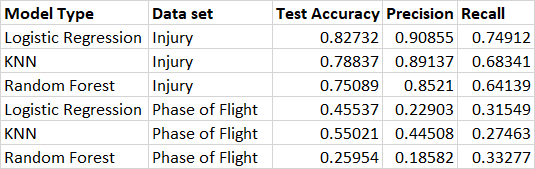

In our evaluation we used GridSearch to get the best hyper parameters for each of these models. 

For visualization we used heat maps to help identify where categorizations were correctly identified as well as miss identified.

Evaluating the injury dataset logistic regression performed the best with an accuracy of 82%, a precision of 90% and a recall of 74%. KNN had a similar precision of 89% but had a lower test accuracy of 78%. One item to consider is the time it took to run each of these models. For our injury dataset logistic regression performed the highest accuracy and was the fastest run time. 

For the Phase of flight dataset we saw significantly lower scores across all metrics. This is to be expected because unlike the injury dataset when predicting phase of flight we have multiple classifications. Our best model was KNN with an accuracy of 55% a precision of 44% and a recall of 27%. Overall we expected KNN to do the best with the multiple categorization dataset. In terms of run time KNN took the longest time however it did show the best results.


In [52]:
from sklearn.model_selection import cross_validate

def InjuryEvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, inj_X, inj_y, scoring=['accuracy','precision','recall']
                            , cv=cv_log, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

In [53]:
from sklearn.model_selection import cross_validate

def PhaseEvaluateClassifierEstimator(classifierEstimator, phase_X, phase_y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, phase_X, phase_y, scoring=['accuracy','precision','recall']
                            , cv=cv_log, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

### Best Models - Injury

In [54]:
# Test Train split for Injury
for train_indices, test_indices in cv_log.split(inj_X,inj_y): 
    X_train_inj = inj_X[train_indices]
    y_train_inj = inj_y[train_indices]
    
    X_test_inj = inj_X[test_indices]
    y_test_inj = inj_y[test_indices]

Logistic regression heat map: this model performed the best however, we did see many misclassifications regarding no injury predicted where there was an injury. Though we want to come to the correct result this result shows a significant issue in a real world application. We don’t want to predict no injury where there might be an injury. This would lead to not properly responing to a plane crash where there could be an injury.

Text(0.5, 1.0, 'Logistic Regression Injury of flight predictions')

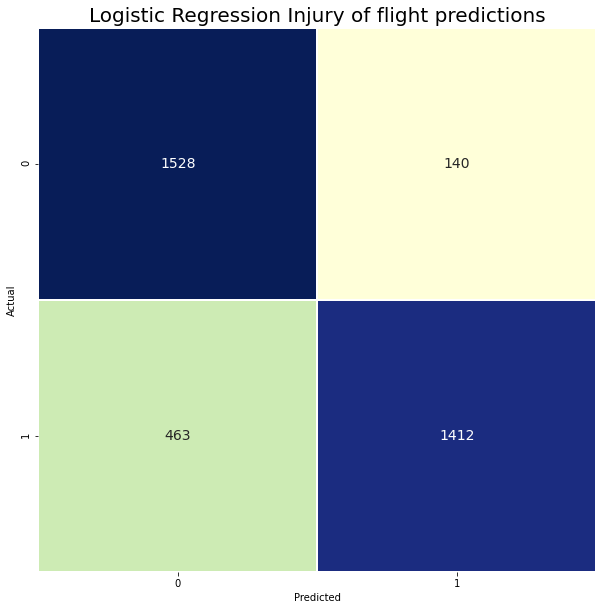

In [55]:
lr_clf_inj_final = LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')
lr_clf_inj_final.fit(X_train_inj,y_train_inj)
log_inj_y = lr_clf_inj_final.predict(X_test_inj)

confusion = pd.crosstab(y_test_inj, log_inj_y, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('Logistic Regression Injury of flight predictions', fontsize = 20)

In [56]:
InjuryEvaluateClassifierEstimator(lr_clf_inj_final, inj_X, inj_y, cv_log)

The average accuracy for all cv folds is: 			 0.82732
The average precision for all cv folds is: 			 0.90855
The average recall for all cv folds is: 			 0.74912
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.836579,0.915918,0.761067
1,0.820209,0.900907,0.741867
2,0.824443,0.902894,0.748800
3,0.825572,0.913215,0.740800
4,0.829805,0.909794,0.753067


Text(0.5, 1.0, 'KNN Injury predictions')

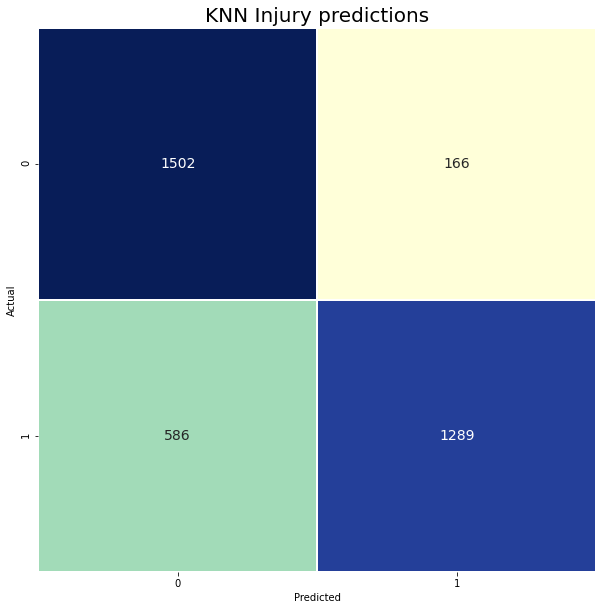

In [57]:
knn_inj_final = KNeighborsClassifier(leaf_size=20, n_neighbors=13, p=1, weights='distance')
knn_inj_final.fit(X_train_inj, y_train_inj)
knn_inj_y = knn_inj_final.predict(X_test_inj)

confusion = pd.crosstab(y_test_inj, knn_inj_y, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('KNN Injury predictions', fontsize = 20)

KNN heat map: KNN was our second best model. However, much like the issue with our logistic regression model we don’t want to predict no injury where there might be an injury. This could lead to an unprepared response from our rescue team.

In [58]:
InjuryEvaluateClassifierEstimator(knn_inj_final, inj_X, inj_y, cv_log)

The average accuracy for all cv folds is: 			 0.78871
The average precision for all cv folds is: 			 0.89135
The average recall for all cv folds is: 			 0.68416
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.796218,0.899515,0.692267
1,0.790573,0.894224,0.685333
2,0.784081,0.884349,0.681067
3,0.784928,0.892731,0.674667
4,0.787750,0.885911,0.687467


Text(0.5, 1.0, 'Random Forest Injury predictions')

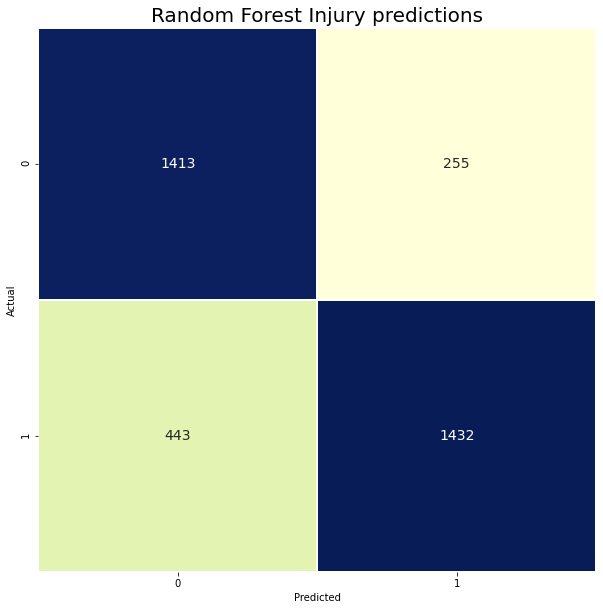

In [59]:
rf_inj_final = RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=50, min_samples_split=50,
                       n_estimators=30, random_state=42)
rf_inj_final.fit(X_train_inj, y_train_inj)
rf_inj_y = rf_inj_final.predict(X_test_inj)

confusion = pd.crosstab(y_test_inj, rf_inj_y, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('Random Forest Injury predictions', fontsize = 20)

Random Forest heat map: this was our least accurate model for prediction injury. It predicted an injury for cases with no injury more often than the others. Though this may lead to an overprepared response from our rescue team we would rather have that opposed to a less prepared response.

In [60]:
InjuryEvaluateClassifierEstimator(rf_inj_final, inj_X, inj_y, cv_log)

The average accuracy for all cv folds is: 			 0.75089
The average precision for all cv folds is: 			 0.8521
The average recall for all cv folds is: 			 0.64139
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.700819,0.859031,0.520000
1,0.756139,0.872513,0.631467
2,0.745978,0.825651,0.659200
3,0.748518,0.854467,0.632533
4,0.802992,0.848844,0.763733


### Best Models - Phase

Phase of flight map:
APPROACH":0

"CLIMB":1

"CRUISE":2

"DESCENT":3

"GOAROUND":4

"HOVER":5

"LANDING":6

"MANEUVERING":7

"STANDING":8

"TAKEOFF":9

"TAXI":10

In [61]:
for train_indices, test_indices in cv_log.split(phase_X,phase_y): 
    X_train_phase = phase_X[train_indices]
    y_train_phase = phase_y[train_indices]
    
    X_test_phase = phase_X[test_indices]
    y_test_phase = phase_y[test_indices]

In [62]:
from sklearn import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr_phase_final = LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')
lr_phase_final.fit(X_train_phase,y_train_phase)
log_phase_y = lr_phase_final.predict(X_test_phase)

print("Accuracy:",metrics.accuracy_score(y_test_phase, log_phase_y))
print("Precision:",metrics.precision_score(y_test_phase,log_phase_y,average='macro'))
print("Recall:",metrics.recall_score(y_test_phase,log_phase_y,average='macro'))

Accuracy: 0.45537287140340577
Precision: 0.229025238041144
Recall: 0.3154852275024576


Text(0.5, 1.0, 'Logistic Regression Phase of flight predictions')

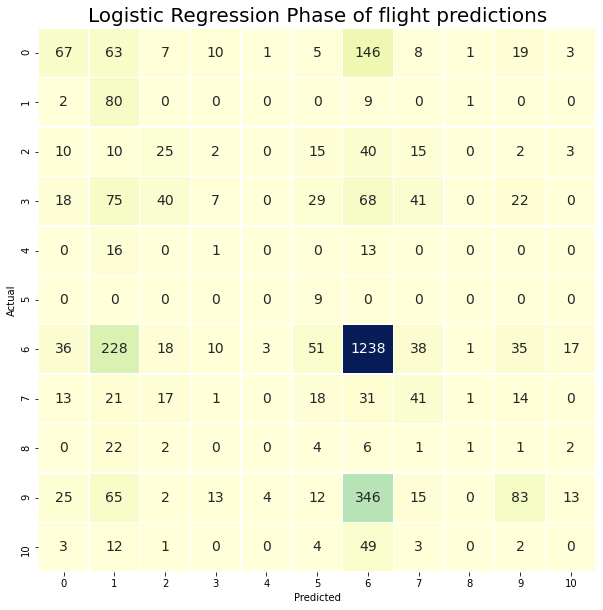

In [63]:
confusion = pd.crosstab(y_test_phase, log_phase_y, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('Logistic Regression Phase of flight predictions', fontsize = 20)

Logistic regression heat map: This was our second-best model at predicting phase of flight. We can see that 6 was the most correctly predicted phase which was landing. However, we see that level 9, takeoff, was mistaken for landing many times. Approach (1) was also miss-predicted as landing as well.

In [64]:
knn_phase_final = KNeighborsClassifier(leaf_size=20, n_neighbors=9, p=1, weights='distance')
knn_phase_final.fit(X_train_phase, y_train_phase)
knn_phase_y = knn_phase_final.predict(X_test_phase)

print("Accuracy:",metrics.accuracy_score(y_test_phase, knn_phase_y))
print("Precision:",metrics.precision_score(y_test_phase,knn_phase_y,average='macro'))
print("Recall:",metrics.recall_score(y_test_phase,knn_phase_y,average='macro'))

Accuracy: 0.5502055196711685
Precision: 0.44507963841719944
Recall: 0.2746267720029174


Text(0.5, 1.0, 'KNN Phase of flight predictions')

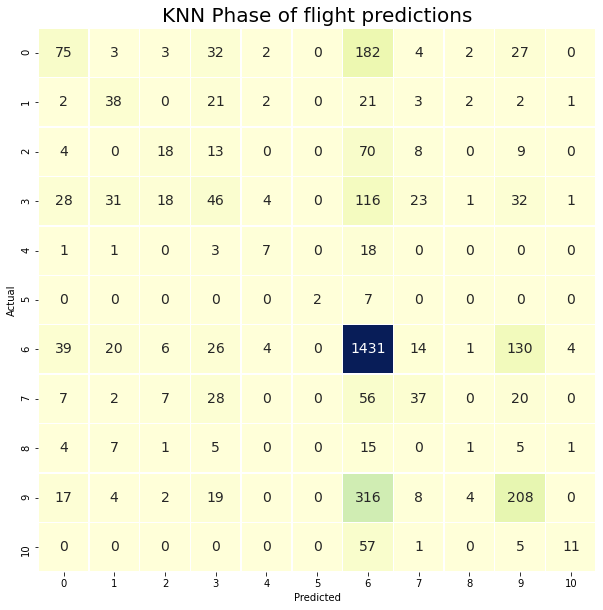

In [65]:
confusion = pd.crosstab(y_test_phase, knn_phase_y, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('KNN Phase of flight predictions', fontsize = 20)

KNN heat map:  This was our best model, but it also had similar issues to the other two. Takeoff and approach were the top miss-categorized predictions and were predicted to be landing.

In [66]:
rf_phase_final = RandomForestClassifier(class_weight= 'balanced', criterion= 'entropy', max_depth= 55, min_samples_leaf= 100, min_samples_split= 500, n_estimators= 90, random_state= 42)
rf_phase_final.fit(X_train_phase, y_train_phase)
rf_phase_y = rf_phase_final.predict(X_test_phase)

print("Accuracy:",metrics.accuracy_score(y_test_phase, rf_phase_y))
print("Precision:",metrics.precision_score(y_test_phase,rf_phase_y,average='macro'))
print("Recall:",metrics.recall_score(y_test_phase,rf_phase_y,average='macro'))

Accuracy: 0.2595419847328244
Precision: 0.18582458429920223
Recall: 0.3327694527031697


Text(0.5, 1.0, 'Random Forest Phase of flight predictions')

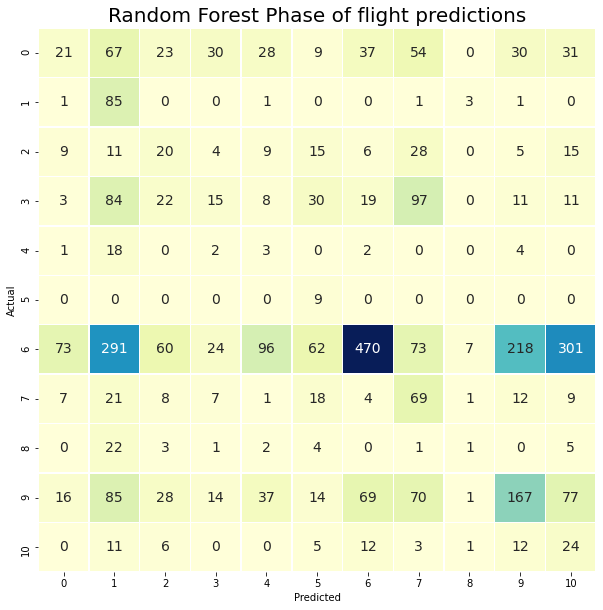

In [67]:
confusion = pd.crosstab(y_test_phase, rf_phase_y, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('Random Forest Phase of flight predictions', fontsize = 20)

Random Forest heat map: This heatmap shows the most interesting story. Landing was predicted for many of the predictions. This includes 1 climb, 4 go-around, 9 takeoff and 10 taxi.

# Modeling and Evaluation 5

Code from: http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/

#### For model comparison we used 6 paired T-tests all with an alpha of .05. This will allow us to identify which models had statically significant different accuracy results.

##### Injury:
Logistic Regression vs. KNN

We achieved a P value of <.0001 which means we reject our hypothesis that these models yield similar results in accuracy and conclude that one model does product a statically higher accuracy. Since we used an alpha of .05 this means that we are 95% confident these two models yeild statically different accuracy results. Given our accuracy scores given earlier we determined that Logistic Regression achieve the better accuracy score.

Logistic Regression vs. Random Forest

We achieved a P value of .011 which means we reject our hypothesis that these models yield similar results in accuracy and conclude that one model does product a statically higher accuracy. Since we used an alpha of .05 this means that we are 95% confident these two models yeild statically different accuracy results. Given our accuracy scores given earlier we determined that Logistic Regression achieve the better accuracy score.


KNN vs. Random Forest

We achieved a P value of .035 which means we reject our hypothesis that these models yield similar results in accuracy and conclude that one model does product a statically higher accuracy. Since we used an alpha of .05 this means that we are 95% confident these two models yeild statically different accuracy results. Given our accuracy scores given earlier we determined that KNN achieve the better accuracy score.



##### Phase:
Logistic Regression vs. KNN

We achieved a P value of .002 which means we reject our hypothesis that these models yield similar results in accuracy and conclude that one model does product a statically higher accuracy. Since we used an alpha of .05 this means that we are 95% confident these two models yeild statically different accuracy results. Given our accuracy scores given earlier we determined that KNN achieve the better accuracy score.

Logistic Regression vs. Random Forest

We achieved a P value of .026 which means we reject our hypothesis that these models yield similar results in accuracy and conclude that one model does product a statically higher accuracy. Since we used an alpha of .05 this means that we are 95% confident these two models yeild statically different accuracy results. Given our accuracy scores given earlier we determined that Logistic Regression achieve the better accuracy score.


KNN vs. Random Forest

We achieved a P value of .005 which means we reject our hypothesis that these models yield similar results in accuracy and conclude that one model does product a statically higher accuracy. Since we used an alpha of .05 this means that we are 95% confident these two models yeild statically different accuracy results. Given our accuracy scores given earlier we determined that KNN achieve the better accuracy score.


•	Models – Injury

•	Logistic Regression

    •	Advantages
        o	Out of all of our models logistic regression ran the fastest
        o	Most accuracy with good scores
        o	Best performance for recall, accuracy, and precision
    •	Disadvantages
        o	Limited in improvement parameters for gridsearch compared to the other models
•	KNN

    •	Advantages
        o	Second best accuracy, recall and precision scores
        o	Gridsearch has many options for hyper parameters
    •	Disadvantages
        o	KNN runs the slowest of all our models
•	Random Forest

    •	Advantages
        o	Ran quickly
        o	Gridsearch can turn many hyper parameters
    •	Disadvantages
        o	Poor performance compared to other options


#### Injury Model Comparison Test

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


In [71]:
from mlxtend.evaluate import paired_ttest_5x2cv

# Logistic Regression vs KNN for injury
t, p = paired_ttest_5x2cv(estimator1=lr_clf_inj_final,
                          estimator2=knn_inj_final,
                          X=inj_X, y=inj_y,
                          random_seed=42)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 11.462
p value: 0.000


In [72]:
# logistic Regression vs Random Forest for injury
t, p = paired_ttest_5x2cv(estimator1=lr_clf_inj_final,
                          estimator2=rf_inj_final,
                          X=inj_X, y=inj_y,
                          random_seed=42)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 3.939
p value: 0.011


In [73]:
#KNN vs Random Forest for Injury
t, p = paired_ttest_5x2cv(estimator1=knn_inj_final,
                          estimator2=rf_inj_final,
                          X=inj_X, y=inj_y,
                          random_seed=42)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 2.879
p value: 0.035


#### Phase Model Comparison T test

Models - Phase

•	Logistic Regression

    •	Advantages

        o	Out of all of our models logistic regression ran the fastest
        o	Second best scores on recall, accuracy and percision
    •	Disadvantages
        o	Limited in improvement parameters for gridsearch compared to the other models
•	KNN

    •	Advantages
        o	Best performance for recall, accuracy, and precision
        o	Gridsearch has many options for hyper parameters
    •	Disadvantages
        o	KNN runs the slowest of all our models
•	Random Forest

    •	Advantages
        o	Ran quickly
        o	Gridsearch can turn many hyper parameters
    •	Disadvantages
        o	Poor performance compared to other options
        o	Many miss-classifications 


In [74]:
#Logistic Regression vs KNN for phase
t, p = paired_ttest_5x2cv(estimator1=lr_phase_final,
                          estimator2=knn_phase_final,
                          X=phase_X, y=phase_y,
                          random_seed=42)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -6.137
p value: 0.002


In [75]:
#Logistic Regression vs random forest for phase
t, p = paired_ttest_5x2cv(estimator1=lr_phase_final,
                          estimator2=rf_phase_final,
                          X=phase_X, y=phase_y,
                          random_seed=42)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 3.143
p value: 0.026


In [76]:
#KNN for phase vs random forest for phase
t, p = paired_ttest_5x2cv(estimator1=knn_phase_final,
                          estimator2=rf_phase_final,
                          X=phase_X, y=phase_y,
                          random_seed=42)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 4.694
p value: 0.005


# Modeling and Evaluation 6

**[10 points] Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.**

#### We looked  at both  logistic regression models to find out what features  were important to finding the correct number of injuries as well as the phase of flight an accident occurred at. For the Injury prediction model the top 5  features were as follows 
#### ev_type_INC
- This is a categorical variable that has been one hot encoded. This is saying that it was an incident that the FAA investigated. If an incident is detected then injuries are more likely to occur.

#### acft_category_AIR
- This is a categorical variable that has been one hot encoded. The category of aircraft that was involved was an Airplane. This probably due to the high number of airplanes in our dataset.

#### far_part_137
- This is a categorical variable that has been one hot encoded. The aircraft that was involved with the accident was following 14 CFR part 137 which means it was an agricultural aircraft. Some reasons why this could be a correlated factor is that there might not be as much regulation for routine tasks such as spraying pesticides.

#### damage_SUBS
- This is a categorical variable that has been one hot encoded. The damage that had occurred to the aircraft was substantial. Substantial damage should link to high injuries.

#### acft_category_HELI
- This is a categorical variable that has been one hot encoded. The category of aircraft that was involved was a helicopter. We expect more injuries to happen with helicopters since they have less safety gear as well as the location of the propeller.

#### For the Logistic regresssion Phase of flight  prediction model the top 5  features were as follows  

##### The best  indicator for what phase of flight an aircraft would go down  was the model of aircraft. We saw other feature categories affect the prediction  but the ones with the model of aircraft dominated the list of top influential features. 

#### acft_model_U-206B
- This is a categorical variable that has been one hot encoded.The aircraft full model code was U-206B. This aircraft was made from the manufacturer Cessna. Since this variable has a high weight it can be indicative of poor build quality.

#### acft_model_Yak 52
- This is a categorical variable that has been one hot encoded.The aircraft full model code was Yak 52. This aircraft was made from the manufacturer Aerostar. Since this variable has a high weight it can be indicative of poor build quality.

#### acft_model_WW-24
- This is a categorical variable that has been one hot encoded.The aircraft full model code was WW-24. This aircraft was made from the manufacturer Israel Aerospace Industries. Since this variable has a high weight it can be indicative of poor build quality.

#### acft_model_WHITTMAN FORMULA VEE
- This is a categorical variable that has been one hot encoded.The aircraft full model code was WHITTMAN FORMULA VEE. This aircraft was made from the manufacturer 	Steve Wittman. Since this variable has a high weight it can be indicative of poor build quality.
#### acft_model_WINDRYDER
- This is a categorical variable that has been one hot encoded.The aircraft full model code was WINDRYDER. This aircraft was made from the manufacturer Windryder Engineering Inc. Since this variable has a high weight it can be indicative of poor build quality.

**Injury Best Est**

In [77]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
numeric_features = ['cert_max_gr_wt',"afm_hrs_last_insp","rwy_width",'rwy_len']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler(with_mean=False))])

categorical_features = ['acft_make', 'acft_model', 'acft_category', 'damage', 'type_fly', 'dprt_state','ev_type', 'ev_state', 'sky_cond_ceil', 'sky_cond_nonceil', 'wx_int_precip', 'phase_flt_spec','ev_city','ev_country','far_part']


categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop="first"))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

the_pipeline_new = Pipeline(steps=[('preprocessor', preprocessor)])

In [78]:
numeric_features_new = ['cert_max_gr_wt',"afm_hrs_last_insp","rwy_width",'rwy_len']

X_columns = injury_df.drop("Injury", axis = 1).copy()
X_columns = the_pipeline_new.fit(X_columns)
X_columns.named_steps["preprocessor"].transformers_[1][1].named_steps["onehot"]

column_name = X_columns.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

column_name = list(column_name)
column_name[:0] = numeric_features_new

In [79]:
coefficients = pd.concat([pd.DataFrame(column_name),pd.DataFrame(np.transpose(lr_inj_best_est.coef_))], axis = 1)
coefficients.columns = ["Features","Weights"]
coefficients["Absolute_Value_Weights"] = coefficients["Weights"]
coefficients["Absolute_Value_Weights"]= coefficients["Absolute_Value_Weights"].abs()
coef_sorted = coefficients.sort_values(by="Absolute_Value_Weights", ascending=False)
coef_sorted = coef_sorted.head(15)

In [80]:
coef_sorted

,Features,Weights,Absolute_Value_Weights
8960,ev_type_INC,-2.864280,2.864280
8844,acft_category_AIR,-2.669153,2.669153
18462,far_part_137,-2.475110,2.475110
8858,damage_SUBS,-2.337375,2.337375
8850,acft_category_HELI,-2.195169,2.195169
8848,acft_category_GLI,-2.189235,2.189235
18450,far_part_091,-2.177739,2.177739
18460,far_part_135,-1.814599,1.814599
18445,ev_country_USA,1.688844,1.688844
9047,phase_flt_spec_TAXI,-1.510707,1.510707


**Phase of Flight best est**

In [92]:
numeric_features = ['cert_max_gr_wt',"afm_hrs_last_insp","rwy_width",'rwy_len','inj_f_grnd','inj_m_grnd',
                    'inj_s_grnd','Total_Fatal_Injuries','Total_Minor_Injuries','Total_Uninjured',
                    'Total_Serious_Injuries','Total_Injuries_Flight']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler(with_mean=False))])

categorical_features = ['acft_make', 'acft_model', 'acft_category', 'damage', 'type_fly', 'dprt_state','ev_type', 'ev_state', 'sky_cond_ceil', 'sky_cond_nonceil', 'wx_int_precip','ev_city','ev_country','far_part']


categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop="first"))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

phase_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [93]:
numeric_features_new = ['cert_max_gr_wt',"afm_hrs_last_insp","rwy_width",'rwy_len','inj_f_grnd','inj_m_grnd',
                    'inj_s_grnd','Total_Fatal_Injuries','Total_Minor_Injuries','Total_Uninjured',
                    'Total_Serious_Injuries','Total_Injuries_Flight']

X_columns = phase_df.drop('phase_flt_spec', axis = 1).copy()
X_columns = the_pipeline_new.fit(X_columns)
X_columns.named_steps["preprocessor"].transformers_[1][1].named_steps["onehot"]

column_name = X_columns.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

column_name = list(column_name)
column_name[:0] = numeric_features_new

In [95]:
coefficients = pd.concat([pd.DataFrame(column_name),pd.DataFrame(np.transpose(log_phase_best_est.coef_))], axis = 1)
coefficients.columns = ["Features","Weights",'1','2','3','4','5','6','7','8','9','10']

coefficients["Absolute_Value_Weights"] = coefficients["Weights"]
coefficients["Absolute_Value_Weights"]= coefficients["Absolute_Value_Weights"].abs()
coef_sorted = coefficients.sort_values(by="Absolute_Value_Weights", ascending=False)
coef_sorted = coef_sorted.head(15)

In [99]:
coef_sorted = coef_sorted[['Features','Weights','Absolute_Value_Weights']]
coef_sorted

,Features,Weights,Absolute_Value_Weights
8594,acft_model_U-206B,-0.467064,0.467064
8810,acft_model_Yak 52,-0.423109,0.423109
8769,acft_model_WW-24,-0.404650,0.404650
8755,acft_model_WHITTMAN FORMULA VEE,-0.211324,0.211324
8760,acft_model_WINDRYDER,-0.205091,0.205091
8685,acft_model_VANS RV-8,-0.189994,0.189994
8764,acft_model_WLAC-1,-0.164586,0.164586
8580,acft_model_Thorpedo T211,-0.156868,0.156868
8609,acft_model_U206G,-0.148584,0.148584
8758,acft_model_WINDLASS AQUILLA,-0.133585,0.133585


# Deployment

**[5 points] How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?**

Our model could be extremely useful to the parties such as the NTSB. The NTSB has publicly available data on
incidents. Creating a model that can classify injury and the phase of flight can improve safety regulations for aircrafts, educate investigators who are tasked with aircraft inspection after an incident has occured, and provide meaningful insights on what features are most important to classification.

For example, safety regulations can improved, because the model could be used to understand the underlying factors that result in incidents that cause injuries. Predicting the broad phase of flight allows the NTSB and FAA to implement more safety measures at these stages of flight. Aircraft inspectors could use the phase of flight model to better predict the aircrafts that are more likely to have an incident at a specific broad phase of flight. Finally, the models provide insight about feature importance for all the interested parties. The model would be deployed so it can be tested on new incidents that have occured. There is more data we can collect that we had not added which include more information about the crew such as crew size, and experience. Certain attributes could be better predictors for both our classification problems. The model would need to be update every couple of months because new data is usually added at the beginning of each month.

# Exceptional Work

For exceptional work we used gridsearch to find the best model for each of our models.

We used these best determined models for each of our Paired T-Tests as well as our Accuracy, Precision and Recall.

Our best models were also used in the heat maps given after each model assessment of Accuracy, Precision and Recall.

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100]
              ,'class_weight': ['balanced']
              ,'random_state': [42]
              ,'solver': ['liblinear']
              ,'max_iter':[1000]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
inj_GridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_log # KFolds = 5
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
inj_GridSearch.fit(inj_X, inj_y)

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100]
              ,'class_weight': ['balanced']
              ,'random_state': [42]
              ,'solver': ['liblinear']
              ,'max_iter':[1000]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
phase_GridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_log # KFolds = 5
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
phase_GridSearch.fit(phase_X, phase_y)

In [ ]:
%%time
#Create KNN Classifier
#random state is not something you can use as a parameter in KNN random state set on CV object
inj_knn_params = {
    "n_neighbors": [3,5,7,9,13],
    "weights": ["uniform", "distance"],
    'leaf_size': (20,40,1),
    'p': (1,2),
#    'metric': ('minkowski', 'chebyshev'),
    }

inj_knn_grid = GridSearchCV(estimator = KNeighborsClassifier(),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = inj_knn_params,
                               cv = cv_log,
                               scoring = 'accuracy')

inj_knn_grid.fit(inj_X,inj_y)

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
#Create KNN Classifier
phase_knn_params = {
    "n_neighbors": [3,5,7,9,13],
    "weights": ["uniform", "distance"],
    'leaf_size': (20,40,1),
    'p': (1,2),
#    'metric': ('minkowski', 'chebyshev'),
    }

phase_knn_grid = GridSearchCV(estimator = KNeighborsClassifier(),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = phase_knn_params,
                               cv = cv_log,
                               scoring = 'accuracy')

phase_knn_grid.fit(phase_X,phase_y)

In [ ]:
%%time
#run random forest on injuries with grid search

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf_inj_rf = RandomForestClassifier(class_weight = 'balanced')

inj_rf_params = {'n_estimators':[5,10,30],
                   'max_depth': [ 10,25,50, 100],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_split': [50],
                   'min_samples_leaf': [50],
                   'random_state': [42]
                  }

inj_rf_grid = GridSearchCV(estimator = clf_inj_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = inj_rf_params,
                               cv = cv_log,
                               scoring = 'accuracy')

inj_rf_grid.fit(inj_X,inj_y)

In [ ]:
%%time
 
# Grid search on Random Forest on  Phase of flight Data Set
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
 
clf_phase_rf = RandomForestClassifier()
 
phase_rf_params = {'n_estimators':[80,90,100],
                   'max_depth': [55,65,75],
                   'criterion': ['gini', 'entropy'],
                 'class_weight':['balanced'],
                   'min_samples_split': [300,400,500],
                   'min_samples_leaf': [75,100,200],
                   'random_state': [42]
                  }
 
phase_rf_grid = GridSearchCV(estimator = clf_phase_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = phase_rf_params,
                               cv = cv_log,
                               error_score = 'raise')
 
phase_rf_grid.fit(phase_X,phase_y)